# Load libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')


In [2]:
#settings
params = {'legend.fontsize': 9,
          'figure.figsize': (15, 5),
         'axes.labelsize': 10,
         'axes.titlesize':11,
         'xtick.labelsize':10,
         'ytick.labelsize':10,
         'axes.grid': True,
         'axes.grid.which': 'both',
         'grid.linestyle': '--',
         'grid.color': 'silver',
         'grid.alpha': 0.5,
         'lines.linewidth': 1,
         'lines.markersize': 4

         }

plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 150
blue = '#005AB5'
red = '#DC3220'

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


In [4]:
df = pd.read_csv('/content/02_TEU_month.csv', index_col=0)

df.index = pd.to_datetime(df.index)
df['Month'] = df.index.month
df['month_sin'] = sin_transformer(12).fit_transform(df['Month'].values.reshape(-1, 1)) # Call fit_transform to apply the sine transformation
df['month_cos'] = cos_transformer(12).fit_transform(df['Month'].values.reshape(-1, 1)) # Call fit_transform to apply the cosine transformation


df.head()

,TEU,Month,month_sin,month_cos
Date,,,,
2010-01-01,493.136,1,0.500000,8.660254e-01
2010-02-01,447.869,2,0.866025,5.000000e-01
2010-03-01,532.599,3,1.000000,6.123234e-17
2010-04-01,485.357,4,0.866025,-5.000000e-01
2010-05-01,596.628,5,0.500000,-8.660254e-01


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180 entries, 2010-01-01 to 2024-12-01
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TEU        180 non-null    float64
 1   Month      180 non-null    int32  
 2   month_sin  180 non-null    float64
 3   month_cos  180 non-null    float64
dtypes: float64(3), int32(1)
memory usage: 6.3 KB


In [6]:
df.describe()

,TEU,Month,month_sin,month_cos
count,180.000000,180.000000,1.800000e+02,1.800000e+02
mean,826.956450,6.500000,-3.454027e-17,-2.713879e-17
std,157.448267,3.461682,7.090792e-01,7.090792e-01
min,447.869000,1.000000,-1.000000e+00,-1.000000e+00
25%,721.414750,3.750000,-5.915064e-01,-5.915064e-01
50%,805.736000,6.500000,-6.123234e-17,-6.123234e-17
75%,930.800000,9.250000,5.915064e-01,5.915064e-01
max,1254.651000,12.000000,1.000000e+00,1.000000e+00


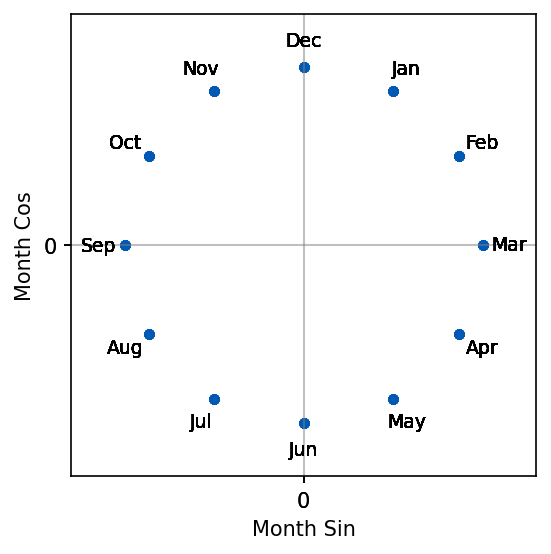

In [7]:
plt.figure(figsize=(4,4))

plt.scatter(df.month_sin , df.month_cos, color= blue)

plt.xlabel('Month Sin')
plt.ylabel('Month Cos')

plt.xticks((0,0))
plt.yticks((0,0))
plt.grid()

plt.xlim(-1.3, 1.3)
plt.ylim(-1.3, 1.3)

plt.vlines(0, ymin=-1.3, ymax=1.3, color='grey', alpha=0.5)
plt.hlines(0, xmin=-1.3, xmax=1.3, color='grey', alpha=0.5)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i, month in enumerate(df.index.month):
    plt.text(df.month_sin[i]*1.15, df.month_cos[i]*1.15,
    month_names[month - 1], ha='center', va='center', fontsize=9)

plt.savefig('Figure_CE.svg')
plt.savefig('Figure_CE.png', dpi=600)

plt.show()

# Load tensorflow libraries

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential  #classe utilizada para criar o modelo sequencial utilizando o keras
from tensorflow.keras.layers import Dense  # Classe utilizada para criar as camadas que são completamente conectadas
from tensorflow.keras.layers import LSTM  # Classe para a rede recorrente utilizando Long Shor Term Memory
from tensorflow.keras.layers import Dropout # Classe utilizada para a camada de dropout (utilizada para evitar o overfiting)
import keras
import os
import random
from sklearn.preprocessing import MinMaxScaler

# Prepare Features/Labels

In [9]:
prev_months = 3 # months lag to use as features

size = -24 #int(len(df_group_month['TEU'].values) * 0.7)

Train, Test = df['TEU'][:size], df['TEU'][size:]

X_train, X_test = df['TEU'][:size], df['TEU'][size-prev_months:]

In [10]:
scaler = MinMaxScaler((0,1))

X_train_scale = scaler.fit_transform(X_train.values.reshape(-1, 1))

X_test_scale = scaler.transform(X_test.values.reshape(-1, 1))

## Train

In [11]:
# prompt: append the features_set with the df[month_sin] and [month_cosisn] data.  considering the need of disconsider teh prev_monhts

features_set_new = []
labels = []
for i in range(prev_months, len(X_train_scale)):
  features_temp = list(X_train_scale[i-prev_months:i, 0])
  features_temp.append(df['month_sin'].iloc[i])
  features_temp.append(df['month_cos'].iloc[i])
  features_set_new.append(features_temp)
  labels.append(X_train_scale[i, 0])

features_set = features_set_new

features_set, labels = np.array(features_set), np.array(labels)

print(features_set.shape) # método utilizado para retornar a dimensão dos dados
print(labels.shape)

features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
labels = np.reshape(labels, (labels.shape[0], 1))
print(features_set.shape)
print(labels.shape)

(153, 5)
(153,)
(153, 5, 1)
(153, 1)


## Test

In [12]:
features_test_new = []
for i in range(prev_months, len(X_test_scale)):
  features_temp = list(X_test_scale[i-prev_months:i, 0])
  # Adjust the index to be within the range of 'df'
  features_temp.append(df['month_sin'].iloc[len(Train) + i - prev_months ])
  features_temp.append(df['month_cos'].iloc[len(Train) + i - prev_months])
  features_test_new.append(features_temp)
test_features = features_test_new

#preparando os dados como entrada para o modelo de previsão
test_features = np.array(test_features)

test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
test_labels = np.array(X_test_scale[prev_months:])

print(test_features.shape)
print(test_labels.shape)

(24, 5, 1)
(24, 1)


# Model Build

In [13]:
# Set seeds for reproducibility
seed = 42
# Enable deterministic operations (TensorFlow 2.9+)
tf.config.experimental.enable_op_determinism()
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Set environment variables for deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'


# Disable GPU (optional, for testing)
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



In [14]:
batch_size = int(16)
Max_neurons = int(256)
epochs = int(100)

X=features_set


In [15]:
def LSTM_model(batch_size, Max_neurons, X, y):

    '''
    Create and compile the LSTM model.
    '''


    tf.keras.backend.clear_session()

    ################
    model = Sequential()
    model.add(LSTM(units = Max_neurons, return_sequences=True, input_shape=(X.shape[1], 1), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = Max_neurons, return_sequences=True, activation='relu'))
    model.add(Dropout(0.2))

    # model.add(LSTM(units = Max_neurons, return_sequences=True, activation='relu'))
    # model.add(Dropout(0.2))

    model.add(LSTM(units = Max_neurons))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=10e-4), loss = 'mse', metrics=['mae'])
    ################
    return model

In [16]:
def scoring(X_true, y_true, model):

    '''
    Evaluate the performance of the model using MAPE, RMSE.
    '''
    pred = model.predict(X_true)
    pred = scaler.inverse_transform(pred).ravel()

    y_true = scaler.inverse_transform(y_true).ravel()

    mape = mean_absolute_percentage_error(y_true, pred)
    rmse = sqrt( mean_squared_error(y_true, pred))


    return mape, rmse

# Loop Serach

In [17]:
%%time
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping


# Set parameters
test_size = 24 #months

batch_size = [8, 16]
Max_neurons = [50, 100, 150]
epochs = [100]
lag_months = 3

# Define K-fold cross-validation with 5 splits
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size = test_size)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


table_results = []
i = 0



for bs in batch_size:
    for units in Max_neurons:
        for e in epochs:
            i += 1
            print(f'i: {i} - lags: {lag_months} - bs: {bs} - units:{units} - epoch: {e}')

            # Initialize lists to store cross-validation scores
            cv_train_scores = []
            cv_val_scores = []

            # Create a fresh model for each hyperparameter combination
            base_model = LSTM_model(bs, units, features_set, labels)

            # Perform time series cross-validation
            for train_idx, val_idx in tscv.split(features_set):
                # Split data into training and validation sets
                X_train, X_val = features_set[train_idx], features_set[val_idx]
                y_train, y_val = labels[train_idx], labels[val_idx]

                # Clone the model for this CV fold to ensure fresh training
                model = tf.keras.models.clone_model(base_model)
                model.compile(optimizer=keras.optimizers.Adam(learning_rate=10e-4), loss='mse', metrics=['mae'])

                # Train with early stopping and validation data
                history = model.fit(
                    X_train, y_train,
                    epochs=e,
                    batch_size=bs,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=0,
                    shuffle=False
                )

                # Calculate scores on training and validation sets
                train_score = scoring(X_train, y_train, model)
                val_score = scoring(X_val, y_val, model)

                cv_train_scores.append(train_score)
                cv_val_scores.append(val_score)

            # Calculate average metrics across all CV folds
            avg_train = np.mean(cv_train_scores, axis=0)
            avg_val = np.mean(cv_val_scores, axis=0)

            # Train a final model on the entire training set with the current hyperparameters
            final_model = LSTM_model(bs, units, features_set, labels)
            final_model.fit(
                features_set, labels,
                epochs=e,
                batch_size=bs,
                validation_split=0.2,  # Use 20% for validation
                callbacks=[early_stopping],
                verbose=0,
                shuffle=False
            )

            # Get test scores using the final model
            test_score = scoring(test_features, test_labels, final_model)

            # Store results
            table_results.append([
                lag_months, bs, units,
                avg_train[0], avg_train[1],  # Training metrics (averaged over CV)
                avg_val[0], avg_val[1],       # Validation metrics (averaged over CV)
                test_score[0], test_score[1],  # Test metrics (final model)
            ])
            mean = (avg_train[0] + avg_val[0])/2


            # Update best model if this configuration performs better
            if i == 1:
                best_model = final_model
                best_score = mean
            else:
                if mean < best_score:
                    best_model = final_model
                    best_score = mean

model = best_model
model.save('best_model.h5')

table_results = pd.DataFrame(table_results)
table_results.columns = ['Lags', 'Batch Size', 'Units',
                        'train_MAPE',  'train_RMSE',
                        'val_MAPE', 'val_RMSE',
                        'test_MAPE', 'test_RMSE']
table_results = table_results.sort_values('train_MAPE').reset_index(drop=True)

table_results

i: 1 - lags: 3 - bs: 8 - units:50 - epoch: 100
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 18.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 13.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
i: 2 - lags: 3 - bs: 8 - units:100 - epoch: 100
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 30.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 15.
3/3 ━━━━━━━━━━━━━━━━━

CPU times: user 6min 34s, sys: 31.7 s, total: 7min 5s
Wall time: 7min 5s


,Lags,Batch Size,Units,train_MAPE,train_RMSE,val_MAPE,val_RMSE,test_MAPE,test_RMSE
0,3,16,150,5.560268,46.657748,4.908179,51.261093,5.715230,74.984777
1,3,8,100,6.569527,53.611775,4.840696,50.865980,6.115980,72.393083
2,3,8,150,7.045648,56.150448,4.865576,51.094236,7.489889,89.403198
3,3,16,100,7.311681,59.933267,5.592035,58.832181,7.153866,94.347662
4,3,8,50,11.012989,88.260398,6.600845,66.192970,5.987860,71.608672
5,3,16,50,11.979822,94.858637,6.344268,63.715231,10.937255,139.980561


In [ ]:
print('-------BEST MODEL PARAMETERS-------')
print('Batch Size: {0:,.0f}'.format(table_results['Batch Size'].values[0]))
print('Units: {0:,.0f}'.format(table_results['Units'].values[0]))
print('Lags: {0:,.0f}'.format(table_results['Lags'].values[0]))

-------BEST MODEL PARAMETERS-------
Batch Size: 16
Units: 150
Lags: 3


# Plot Best Model Results

In [ ]:
test_size = 24
n = 3

model = best_model
pred = model.predict(features_set)
pred = scaler.inverse_transform(pred)

scores = scoring(features_set, labels, model )

train_mape = scores[0]
train_rmse = scores[1]


print('-----MODEL EVALUATION WITH THE PREVIOUS {:,.0F} MONTHS AS FEATURES-----'.format(n))
print(f'MAPE: {train_mape:.2f}%')
print(f'RMSE: {train_rmse:.2f}')



5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
-----MODEL EVALUATION WITH THE PREVIOUS 3 MONTHS AS FEATURES-----
MAPE: 4.57%
RMSE: 45.92


In [ ]:
test_size = test_size
labels_1d = scaler.inverse_transform(labels)

labels_1d = labels_1d.reshape(-1)
pred = pred.ravel()

Train = pd.DataFrame({'Train': labels_1d , 'Previsao': pred}, index=df[n:-test_size].index)

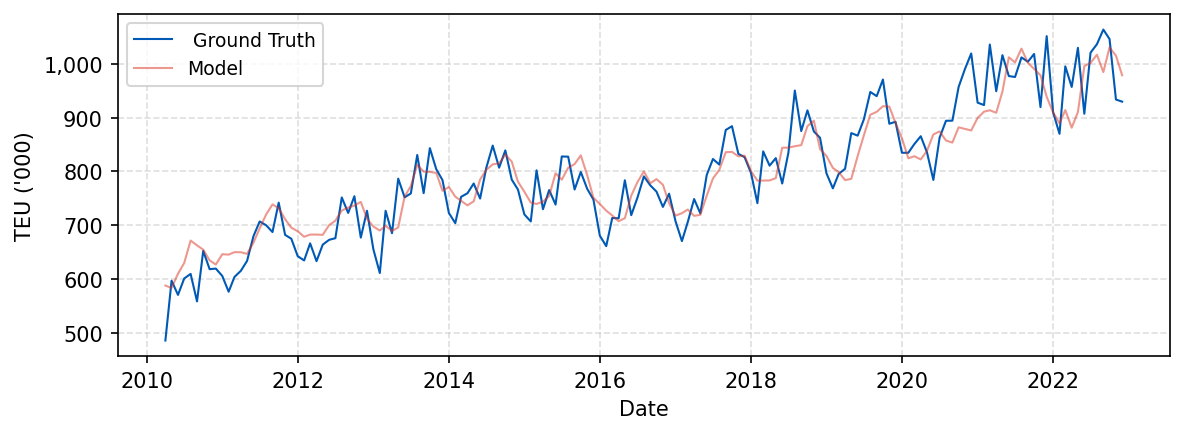

In [ ]:
plt.figure(figsize=(8,3))

plt.plot(Train.index, Train.Train, label=' Ground Truth', color= blue) # Adjust x-axis data
plt.plot(Train.index, Train.Previsao, label='Model', color= red, alpha=0.5) #Adjust x and y-axis data

# Format y-axis labels with thousands separator
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.legend(fontsize=9)

#plt.title("LSTM - Train MAPE: {0:.2f}%".format(scores[0]))
plt.xlabel('Date')
plt.ylabel("TEU ('000)")

plt.tight_layout()

plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


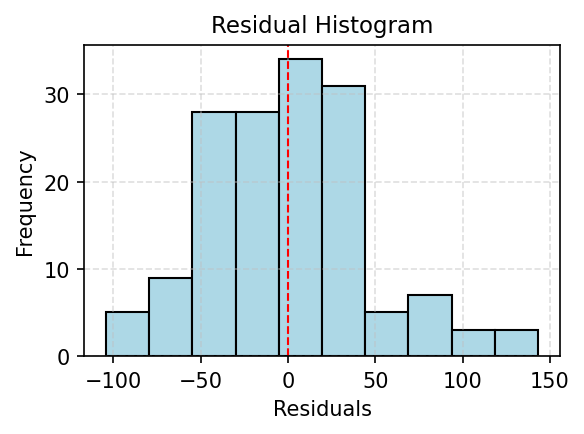

In [ ]:
# Assuming 'model' and 'test_features' are defined from the previous code
residuals = scaler.inverse_transform(labels) - scaler.inverse_transform(model.predict(features_set))

plt.figure(figsize=(4, 3))
plt.hist(residuals, bins=10, color= 'lightblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.tight_layout()

plt.savefig('Figure_residuals_CE-LSTM.svg')
plt.savefig('Figure_residuals_CE-LSTM.png', dpi=600)


plt.show()


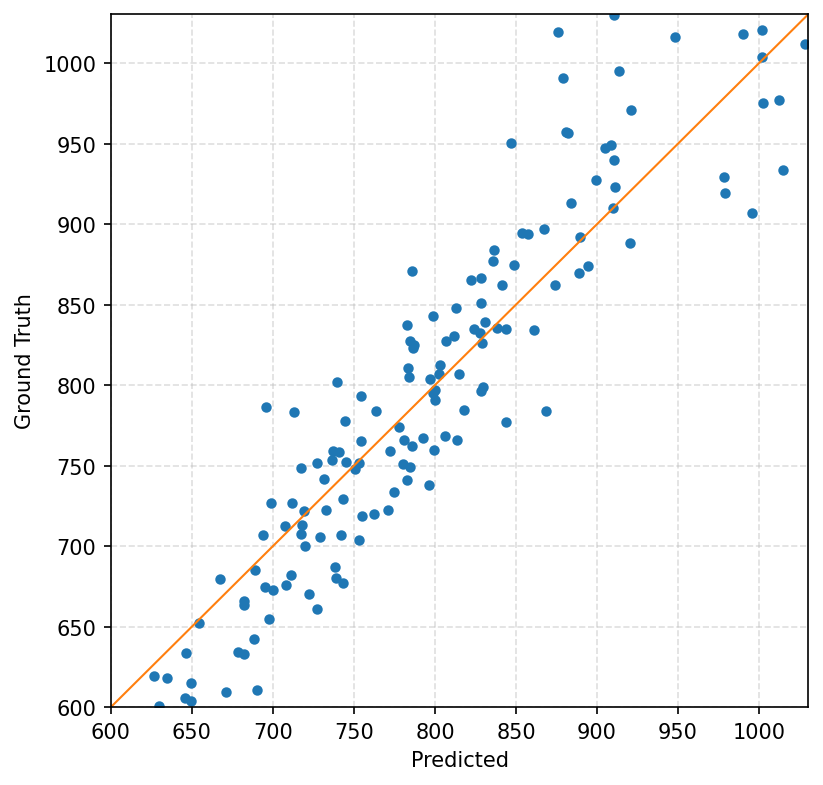

In [ ]:
# plot Q-Q plot
plt.figure(figsize=(6,6))
plt.plot(Train.Previsao, Train.Train, 'o')
plt.plot([min(Train.Previsao.min(), Train.Train.min()), max(Train.Previsao.max(), Train.Train.max())],
        [min(Train.Previsao.min(), Train.Train.min()), max(Train.Previsao.max(), Train.Train.max())])
plt.xlim(600, max(Train.Previsao))
plt.ylim(600, max(Train.Previsao))

plt.xlabel('Predicted')
plt.ylabel('Ground Truth')

plt.show()



In [ ]:
test_size = 24
#previsão utilizando o modelo gerado
previsao = model.predict(test_features)
previsao = scaler.inverse_transform(previsao).ravel()

test_labels_1d = scaler.inverse_transform(test_labels)
test_labels_1d = test_labels_1d.reshape(-1)

result = pd.DataFrame({'Test': test_labels_1d , 'Previsao': previsao}, index=df[-test_size:].index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Train MAPE: 4.57%
Train RMSE: 45.92
Test_MAPE: 5.72%
TestRMSE: 74.98


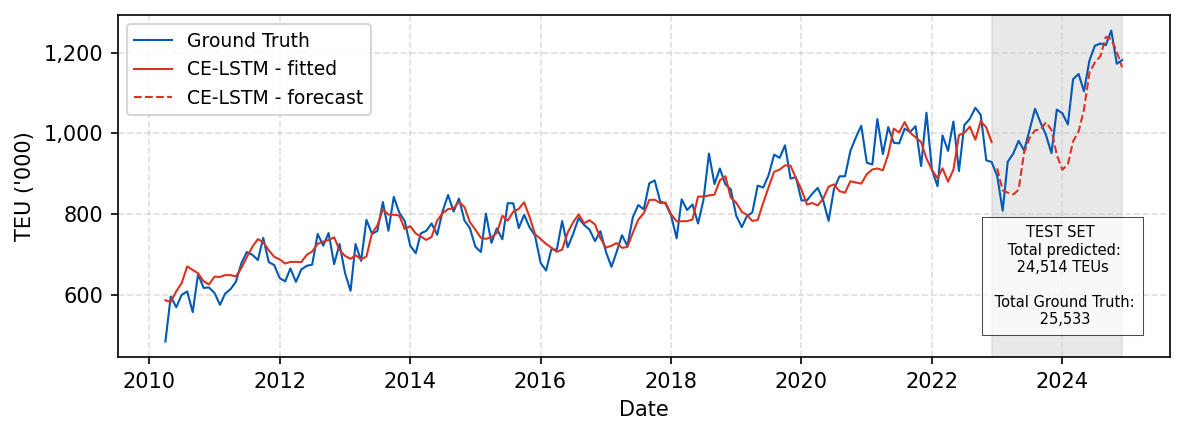

In [ ]:
scores = scoring(test_features, test_labels, model)

test_mape = scores[0]
test_rmse = scores[1]

print(f'Train MAPE: {train_mape:.2f}%')
print(f'Train RMSE: {train_rmse:.2f}')

print(f'Test_MAPE: {test_mape:.2f}%')
print(f'TestRMSE: {test_rmse:.2f}')

prediction_series = np.append(Train.Previsao.values, result.Previsao.values)

Real_test = result.Test.sum()
Predicted_test = result.Previsao.sum()

#####################################################################3
plt.figure(figsize=(8,3))

sns.lineplot(x= df.index[3:], y= df.TEU[3:] , label='Ground Truth', color= blue)
sns.lineplot(x= Train.index, y= Train.Previsao, label='CE-LSTM - fitted', color= red)
sns.lineplot(x= result.index, y= result.Previsao, label='CE-LSTM - forecast' ,linestyle = '--', color= red)

plt.axvspan(Train.index[-1], result.index[-1], color='lightgrey', alpha=0.5)

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.legend(fontsize=9)

#plt.title("LSTM - Test - MAPE: {0:.2f}%".format(test_mape))
plt.xlabel('Date')
plt.ylabel("TEU ('000)")

plt.text(result.index[int(round(result.shape[0]/2 , 0 ))], result.Test.min()*0.8,
         'TEST SET \n Total predicted:\n {:,.0f} TEUs \n\n Total Ground Truth:\n {:,.0f}'.format(Predicted_test, Real_test),
         fontsize=7,
         bbox=dict(facecolor='white',
                   alpha=0.7,
                   edgecolor='black',
                   linewidth=0.5),
                   va='center',
                   ha='center')

plt.tight_layout()

plt.savefig('Figure_CE-LSTM.svg')
plt.savefig('Figure_CE-LSTM.png', dpi=600)

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


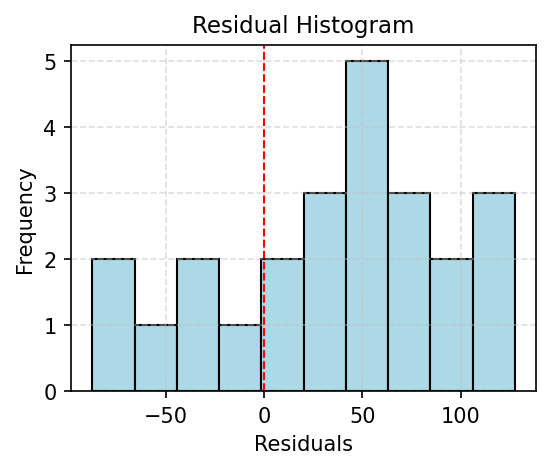

In [ ]:
# Assuming 'model' and 'test_features' are defined from the previous code
residuals_test = scaler.inverse_transform(test_labels) - scaler.inverse_transform(model.predict(test_features))

plt.figure(figsize=(4, 3))
plt.hist(residuals_test, bins=10, color= 'lightblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.show()